<a href="https://colab.research.google.com/github/Iamsbharti/ML101-Lab/blob/master/neural_network_scratch_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Derivative**

In [6]:
# a hyperbola
def f(x):
  return 3 * x ** 2 -4*x +5

In [7]:
f(3.0)

20.0

In [67]:
xs = np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [10]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

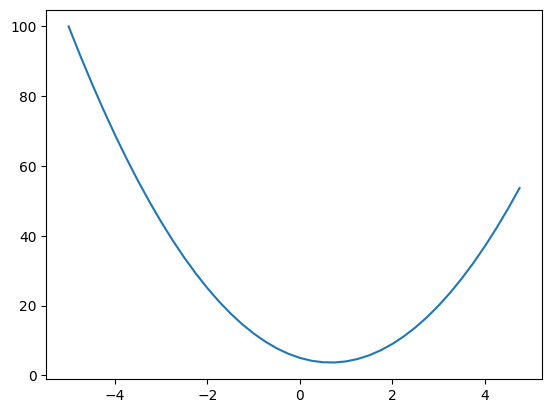

In [11]:
plt.plot(xs,ys)

-  a derivative is to find the amount of change recorded when input of the function is nudged in +ve /-ve direction ,the slope of the change.

In [66]:
h = 0.0000001 # amount of change
x = 2/3
# (f(x + h) - f(x)) /h

In [14]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b +c
print(d)

4.0


In [1]:
h = 0.0001 # amouint of change
# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
a +=h

d2 = a * b + c
print("d1:", d1)
print("d2:", d2)
print('slope:', (d1 - d2)/h)


d1: 4.0
d2: 3.999699999999999
slope: 3.000000000010772


- we are building a data-structure to store the value of a expression , from which values and operand they were created.
- _children is a set which stores the input used in generating the matematical expression
- _op stores the operand
- these are constructors to the `Value` class.

In [68]:
# neural networks needs mathematical operation so this is a datastructure to represent them.
# backpropagation
'''
we are going to derive derivate of each node with respect to the previous node
so derivative of L w.r.t L is 1
- L w.r.t d
- L w.r.t f
.... so on
- derivative of output w.r.t its leaf nodes.
`grad` varibale stores the derivative of node w.r.t to prev node. initialized to 0.0
'''

class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self.grad = 0.0
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    out = Value(self.data + other.data, (self,other), '+')
    return out

  def __mul__(self,other):
    out = Value(self.data * other.data, (self,other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) +1)
    out = Value(t, (self,), 'tanh')
    return out


a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'

d = e + c ; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [9]:
 print(d._prev,d._op)

{Value(data=10.0), Value(data=-6.0)} +


### because these mathematical expression can get larger , we are now going to build a way to visulaize these expression graphs

In [71]:
from graphviz import Digraph
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'},) # left to right graph

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph ; create a rectangular ('record') node for it
        dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            # if this values is a result of some operation , cretae an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # now connect this node to it
            dot.edge(uid + n._op , uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


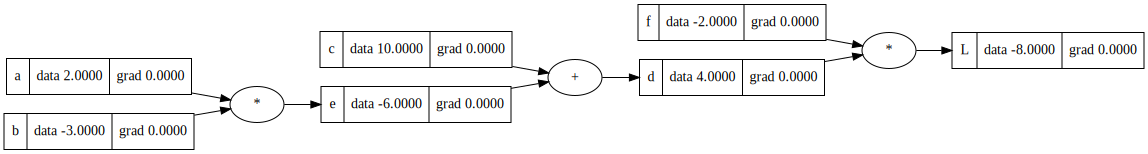

In [72]:
draw_dot(L)

### let's do the backpropagtion manually


In [30]:
def calculate_derivate():
  # changing L by h will give derivate to 1
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  # calculate L2 by nudings the a value by `h`
  L2 = L.data + h

  print((L2 - L1)/h)
calculate_derivate()

1.000000000000334


In [31]:
def calculate_derivate_1():
  h = 0.0001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  # calculate L2 by nudings the a value by `h` to `a`
  a = Value(2.0 + h, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()

6.000000000021544


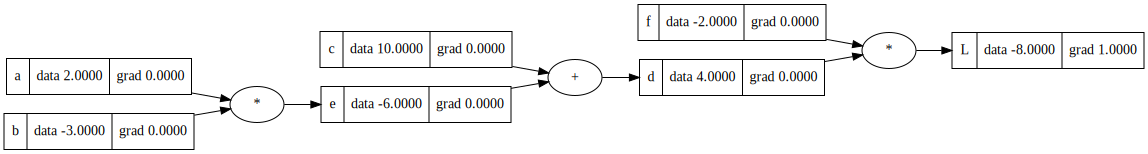

In [73]:
L.grad = 1
draw_dot(L)

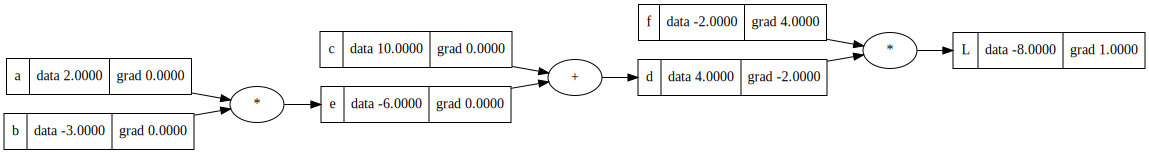

In [74]:
# now let's calculate grad for `d` first
'''
L = d * f
  dL/dd =??? => f

  - calculate
  . (f(x + h) - f(x)) / h
  . ((d + h) * f - d * f) / h)
  . (d * f + h * f - d * f) / h)
  . h * f / h
  . => f

  so from this calculation grad of `d` w.r.t `L` will be `d`
'''
f.grad = 4.0
d.grad = -2.0
draw_dot(L)

In [63]:
# now using calculate_derivate method verify the grad
# dL/dd = -2
def calculate_derivate_2():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  # change `d` by `h`
  d.data += h

  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()

-2.000000000000668


-2.000000000000668


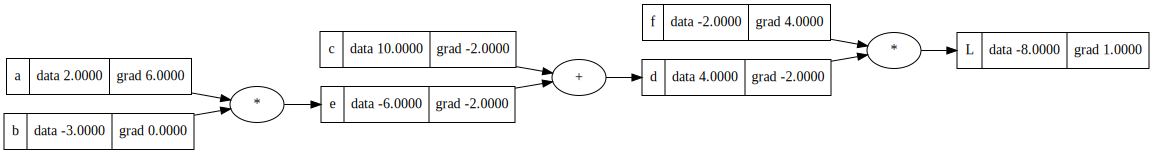

In [84]:
# dL/df = -4
def calculate_derivate_3():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  # change `f` by `h`
  f = Value(-2.0, label='f')
  f.data += h
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()
draw_dot(L)

In [76]:
# now dL/dc
'''
- we know how L is sensitive to d & f
- no we want to know how L is sensitive to c

first we compute how c impacts d

- dd / dc = ? 1.0 # by calculas rule of sum function
- let's derive this
- d = c + e
. (f(x + h) - f(x)) / h
. (c + h + e) - (c + e) / h
. c + h + e - c - e / h
. h / h
. => 1.0

simialrly by symmetry
dd / de = 1.0
- derivative of sum operation is 1.0 (local derivative)

- how these info will help in computing how c impacts L (output)??
- by chain rule

The chain rule may also be expressed in Leibniz's notation. If a variable z depends on the variable y,
which itself depends on the variable x (that is, y and z are dependent variables),
then z depends on x as well, via the intermediate variable y.

- a dot prodct of the 2 derivatives

"If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man,
then the car travels 2 × 4 = 8 times as fast as the man."

dL / dc =??

KNOW:
dL / dd = -2.0
dd / dc = 1.0

by chain rule
=> dL / dc = (dL / dd) * (dd / dc) => -2.0 * 1.0
=> since dd/dc is 1.0 so basically we copy over the derivateive dL/dd to dL/dc
- so what + node does is routes the local gradient

c.grad = -2.0 * 1 = -2.0
e.grad = -2.0 * 1 = -2.0
'''
c.grad = -2.0
e.grad = -2.0

In [77]:
# lets vierify this with calculate_derivative
# dL/dc = -2
def calculate_derivative_3():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  # nudge `c` by `h`
  c = Value(10.0 + h, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()

-2.000000000000668


-2.000000000000668


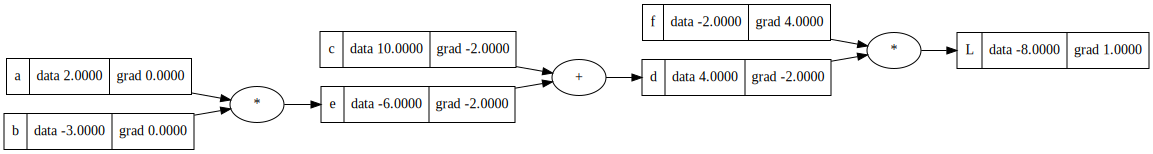

In [78]:
# dL/de = -2
def calculate_derivative_4():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'
  # nudge `e` by `h`
  e.data += h

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()
draw_dot(L)

In [79]:
# so far derivatives are
'''
- dL / de = -2

now we have one node left; lets calcualte derivative of that
de / da = lcoal gradient ; how `e` changes w.r.t `a`
dL / da = (dL / de )* (de / da)

=> e = a * b
=> de / da ? = b # from oor first derivative derivation of `d`
--- + --
=> de / db ? = a

a.grad = (-2.0 * -3.0) = 6.0
b.grad = (-2.0 * 2.0) = -4.0
'''

a.grad = 6.0
b.grad = -4.0

In [52]:
# lets vierify this with calculate_derivative
# dL/da = 6.0
def calculate_derivative_5():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  # nudge `a` by `h`
  a = Value(2.0 + h, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()

6.000000000000227


3.9999999999995595


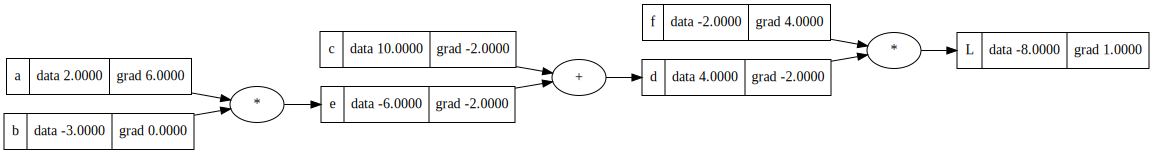

In [85]:
# dL/df = -4
def calculate_derivate():
  h = 0.001
  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'

  d = e + c ; d.label = 'd'
  # change `f` by `h`
  f = Value(-2.0 + h, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)
calculate_derivate()
draw_dot(L)

# back-propagtion is recursive application of chain - rule through out the graphs

In [57]:
# we try to move the L up by changing the leaf nodes by some value or step size
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# now apply forward pas
e = a * b
d = e + c
L = d * f

print(L.data)


-5.900192000000001


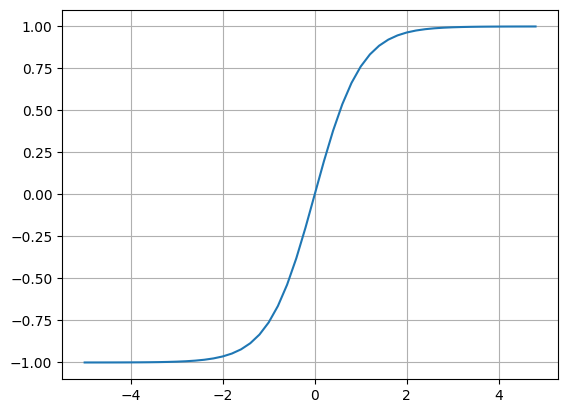

In [61]:
# now we will build a sample neural net , and a multilayer neuron called perceptron

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

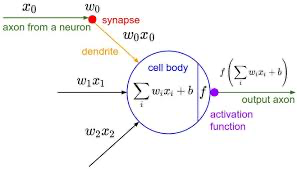

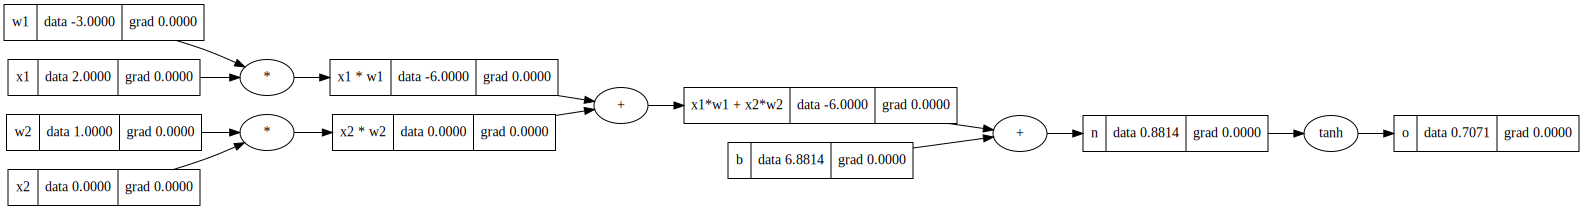

In [87]:
# inputs x1,x2 2 dim neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights; w1,w2 ;synaptics
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

# bias
b = Value(6.8813735870195432,label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label='x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
# output with a activation function (tanh)
o = n.tanh(); o.label='o'
draw_dot(o)